#**Is it possible to predict the outcome of stop and search occurences?**
By Frank Perez

#**Introduction**
In a span of 12 months, over 200,000 stop and search occurences were conducted, and reported, by the Metropolitan Police Service in London. This data is hosted on data.london.gov.uk, and used on a met.police.uk dashboard to track and display this recorded data. This dataset, collected from 
11/01/20-10/31/21, contains several features, including location, demographic data, reasoning for stop, and the outcome of the stop. 

In order to try to predict the outcome of these stop and search occurences, specifically if the police took any action. To achieve this, a tree classifier, and feature selection will be used to find out which features mostly affect the data.


In [1]:
# Importing all the libraries needed
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt     
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import tree
import graphviz



# Mounting Google Drive on runtime's virtual machine
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Reading the dataset and storing it in a dataframe
data_dir = "/content/drive/My Drive/Stops_LDS_Extract_12MonthsToEnd_202110.csv"
df = pd.read_csv(data_dir,encoding='cp1252')

In [3]:
sns.set_context('notebook') 
rcParams['figure.figsize'] = 11.7,8.27

# **Initial data exploration**
How much data is there?
What are the types of the variables?  (beware of categorical data encoded as numbers)
How many NA or missing values in the data?
Does the data set contain much obviously bad data?
Explain the meaning of at least the main variables.

To begin, it is imporant to understand the data being worked on. Items like the number of occurences, the different features, and the type of features. 

---



In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243185 entries, 0 to 243184
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Date                         243185 non-null  object 
 1   Stop Ref                     243185 non-null  object 
 2   Time                         243185 non-null  object 
 3   Borough of Stop              243185 non-null  object 
 4   Borough Code                 243185 non-null  object 
 5   Officer OCU                  243185 non-null  object 
 6   Search Type                  243185 non-null  object 
 7   Subject                      243185 non-null  object 
 8   Reason for Stop              243185 non-null  object 
 9   Outcome                      243185 non-null  object 
 10  Outcome Reason               243185 non-null  object 
 11  Apparent Age                 241170 non-null  float64
 12  Gender                       243185 non-null  object 
 13 

Looking at the output, there are exactly 243,185 rows and 18 different columns. The majority of the data is categorical/object type, with only 2 columns being numeric. Columns 0-5 contains data about time and location, 6-10 contains data specfically about the stop reasoning and outcome, and cloumns 12-16 are all demographic data. 

To get a firm understanding on what an entry looks like, we should examine the first 3 entries.  

In [5]:
df.head(3)

,Date,Stop Ref,Time,Borough of Stop,Borough Code,Officer OCU,Search Type,Subject,Reason for Stop,Outcome,Outcome Reason,Apparent Age,Gender,Ethnic Appearance Code,EA Group,Self-defined Ethnicity Code,SDE Group,Count
0,2020-11-01,KGZS00065320,08:56:00,Barking and Dagenham,KG,East,STOP_SEARCH,Person ...,B Drugs (s.23 Misuse of Drugs Act),1 No further action,Not Applicable ...,50.0,F ...,1 White - North European ...,White,W9 Any other Wh,White,1
1,2020-11-01,KGZS00065305,22:10:00,Barking and Dagenham,KG,East,STOP_SEARCH,Person ...,B Drugs (s.23 Misuse of Drugs Act),1 No further action,Not Applicable ...,19.0,M ...,1 White - North European ...,White,W9 Any other Wh,White,1
2,2020-11-01,KGZS00065304,22:10:00,Barking and Dagenham,KG,East,STOP_SEARCH,Person ...,B Drugs (s.23 Misuse of Drugs Act),1 No further action,Not Applicable ...,18.0,M ...,1 White - North European ...,White,W9 Any other Wh,White,1


This peek at the first few entries shows the significance of several columns. At first glance, it seems Stop Ref, Borough Code, Officer OCU, and Count columns don't seem to be usable for what we're trying to accomplish in this project. However, to further understand the categorical types, it is important to look at the amount of different values within those columns.

In [6]:
df.nunique()

Date                              365
Stop Ref                       243185
Time                             1440
Borough of Stop                    34
Borough Code                       33
Officer OCU                        39
Search Type                         1
Subject                             3
Reason for Stop                    12
Outcome                             6
Outcome Reason                     16
Apparent Age                       86
Gender                              4
Ethnic Appearance Code              8
EA Group                            4
Self-defined Ethnicity Code        20
SDE Group                           4
Count                               1
dtype: int64

This output clarifies a few things. Stop Ref is simply a unique identifier for each row, making it not of use for us. In additon, both Subject and Count only have one value, making it also not of use for our notebook. Borough code seems to be an short identifier for the Burough Stop, so it also can be removed. However, there are several different columns that are worth looking into. For example, the Subject columns having 3 values, the Outcome column have 6 values, and the Gender column having 4 values. 

In [7]:
df['Outcome'].value_counts()

1 No further action                       180258
4 Arrested                                 29961
13 Community resolution                    20506
11 Penalty Notice (PND/FPN)                 8780
12 Postal Charge Requisition / Summons      3493
14 Caution (simple or conditional)           187
Name: Outcome, dtype: int64

Here it is shown that the value of the Outcome is primarily No further action. This suggests that the data is imbalanced, and should be dealt with before we begin with apply machine learning. Additionally, since there are several categories are below 10,000, it possible to merge these categories into a single category. 



A similar column to look into is the Outcome Reason column. 

In [8]:
df['Outcome Reason'].value_counts()

Not Applicable                                                                                        180257
B Drugs                                                                                                38583
O Other Offence (not listed above)                                                                      5914
T Theft Fraud & Counterfeit Offences                                                                    5566
D Weapons Points & Blades Offences                                                                      4428
R Road Traffic Offences                                                                                 3797
W Criminal Justice Offences (inc Recall Wanted Circulations Wanted on Warrant & Bail Act offences)      1061
V Violence (inc Common Assault ABH and GBH)                                                             1054
P Public Order Offences (inc s.1-5 POA Drunkeness Assault on Police & Breach of the Peace)               877
L Criminal Damage A

These categories list the reasons for their outcome. Similar to the previous column, this column is mostly made up by the Not Applicable category. However, in this column there are many different categories, but it is possible to group some of these categories if necessary. 

Another possibly important column to look into is the Subject column.

In [9]:
df['Subject'].value_counts()

Person                                                                                                                                                                                                                                                             180715
Person and Vehicle                                                                                                                                                                                                                                                  58582
Vehicle                                                                                                                                                                                                                                                              3888
Name: Subject, dtype: int64

Here there is an overwhelming amount of Person entries. Meaning the majority of interactions happen outside of vehicles. It is also safe assume that the Vehicle column refers to searches were police examined a vehicle without a driver. A look into the Gender column might help with clarifying this. 

In [10]:
df['Gender'].value_counts()

M                                                     220885
F                                                      18819
V                                                       3278
U                                                        203
Name: Gender, dtype: int64

This output shows the majority of the entires are male or female, but there are some exceptions. U most likely means unknown, and V could mean vehicle. Both categories added together almost add up to the amount of Vehicle values in the Subject column. They could possible be used interchangeably when a driver can't be found at the time of the stop. 

Lastly, it is important to know how many missing values there are in the dataset.

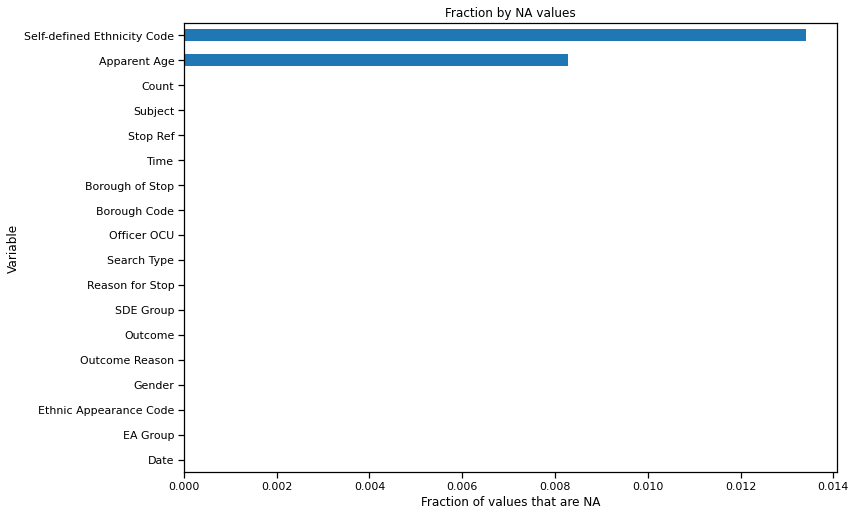

In [11]:
df.isna().mean().sort_values().plot.barh()
plt.title('Fraction by NA values')
plt.ylabel('Variable')
plt.xlabel('Fraction of values that are NA');

This graph shows that there are only missing values in Self-defined Ethnicity Code, and Apparent Age. In addition, they only make up 0.02 percent of the dataset. This means that we can safely remove these rows since they make up such a small fraction of the entries. 

# **Data Cleaning and Preprocessing**

 #### What are columns and rows that can be removed?

In [12]:
df = df.drop(['Stop Ref', 'Borough Code', 'Search Type', 'Count' ], axis=1) 
df.dropna(inplace = True)

The listed columns don't hold any information that will be helpful. The first 2 columns are unique identifiers, and the last two are columns that hold only 1 value. In both cases, these columns won't be relevant for predicting outcomes. 

Since such a small amount of data was missing data, data with missing values was dropped entirely since it wouldn't affect outcome prediction.


#### What Subject will we focus on?

In [13]:
df = (df[df['Subject'].str.contains('Vehicle') == False])

The data was split into three subjets, Person, Vehicle, and Person & Vehicle. In order to have a more consistant outcome prediction, Vehicle, and Vehicle & Person rows were removed to focus on the majority of the data (Person).  

#### What outcomes can be grouped together?

In [14]:
df['Further Action'] = (df['Outcome'] != '1 No further action')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Using the Outcome column values, an additonal column was made to simply whether or not further action was taken by police after the stop and search. This will be the main target of our classification algorithm. 

In [15]:
df['Male'] = (df['Gender'].str.contains('M') == True)
df['Male'].value_counts()

True     165156
False     15556
Name: Male, dtype: int64

Addtionally, the Gender column can be simplified to male or not. It will make keeping track of gender much easier. 

#### What useful columns can be added?

In [16]:
# Date Time Code Here
df['Time'].value_counts()
df['Time'] = pd.to_datetime(df['Time'])
df['hour'] = df['Time'].dt.hour

Using the the extact time makes it difficult to group certain events and view trends. To help with this, exact time was coverted into an additional column named Hour. 

In [17]:
df = df.replace(to_replace = ['B Drugs (s.23 Misuse of Drugs Act)', 'D Weapons Point & Blades (s.1 PACE s.139 CJ Act)',
                'A Stolen property (s.1 PACE)'],value =  ['Drugs', 'Knife point', 'Theft'])

df = df.replace(['F Going equipped (s.1 PACE)', 'L Articles to cause Criminal Damage (s.1 PACE)',
                'K s.60 CJPO Weapons', 'Z Fireworks (s.1 PACE)','C Firearms (s.47 Firearms Act)',
                'N Terrorism (s.43 & s.43A TACT)','Y Psychoactive Substances',
                'O Other Object (see Annex A of code A PACE)','Q Terrorism (s.47A TACT)','K s.60 CJPO Weapons'],
                'Other')

In [18]:
df = df.replace(['1 No further action','4 Arrested','13 Community resolution',
                 '11 Penalty Notice (PND/FPN)'],
                ['No further action','Arrest','Community Resolution',
                 'Fine'])
df = df.replace(['12 Postal Charge Requisition / Summons',
                 '14 Caution (simple or conditional)'], 'Other')

The exact name of values in the certain columns are quite long and often begin with a unique code letter. To simplfy things, they were renamed into simple category names. 

# **Data Exploration and Initialization**

#### What are the most common reasons for a stop and search?

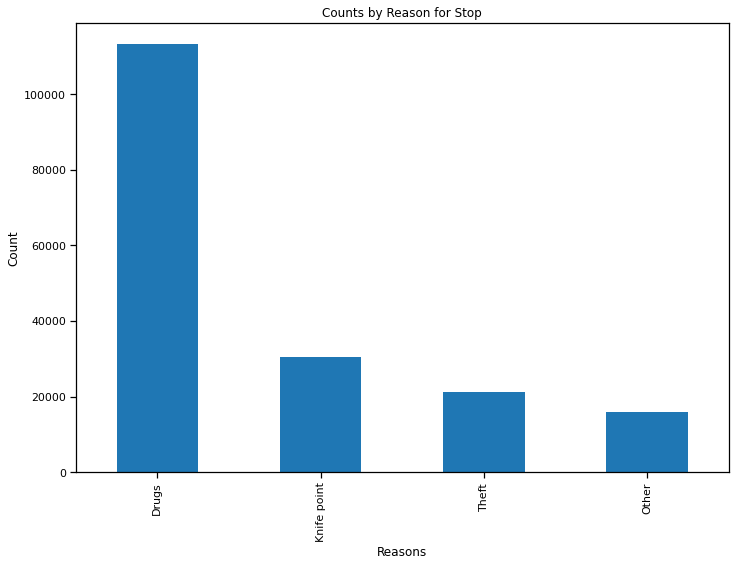

In [19]:
df['Reason for Stop'].value_counts().plot(kind='bar')
plt.title('Counts by Reason for Stop')
plt.xlabel('Reasons')
plt.ylabel('Count');

The data shows that the majority of recorded people that were stopped on suspicion of misuse of drugs, followed up by suspicion of having pointed weapons, and having stolen property. Another important piece of data to look at would be the actual outcome of these stops.

#### What were the outcome of these stops?

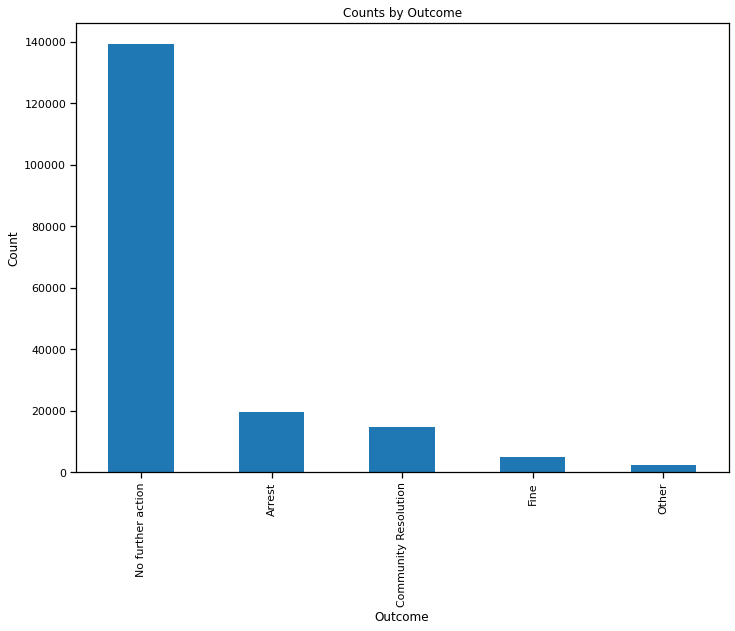

In [20]:
df['Outcome'].value_counts().plot.bar()
plt.title('Counts by Outcome')
plt.ylabel('Count')
plt.xlabel('Outcome');

Similarly to the previous image, this the most common outcome is No further action. This means that the person stopped was let go and no punishment or warning was given. In order to get more accurate predictions, it might be best to get an equal test size when applying machine learning. 

#### Are there any age groups that get stopped more often?

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


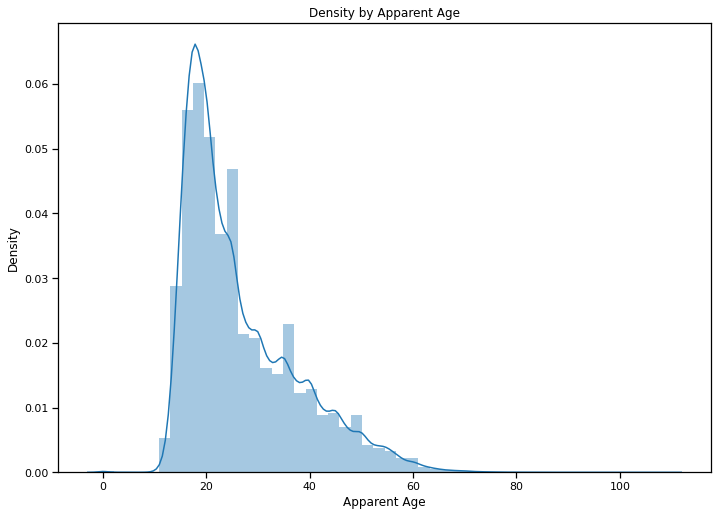

In [21]:
sns.distplot(df['Apparent Age'])
plt.title('Density by Apparent Age');

Although there are people from most ages in the set, the majority of people stopped range from people in their mid teens, to people in their late twenties. With this it's possible to see common ages of those stopped, but not the reason.

#### Are there any noticeable trends for the stop outcomes by age groups?

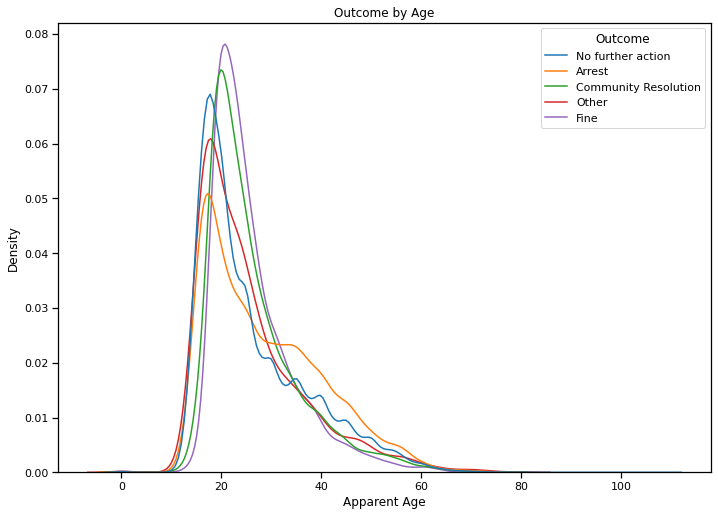

In [22]:
sns.kdeplot('Apparent Age', hue='Outcome', data=df, common_norm=False)
plt.title('Outcome by Age');

This graph shows some similarities with the previous one, but this shows several noticeable trends. First, community resolution and all other outcomes are almost entirely lined up with eachother. Second, the No further action seems to follow the previous chart very closely. And lastly, that the arrest out does not peak like all the other outcomes, and is the most spread out among all age groups. 

#### Does time of day show any trends?

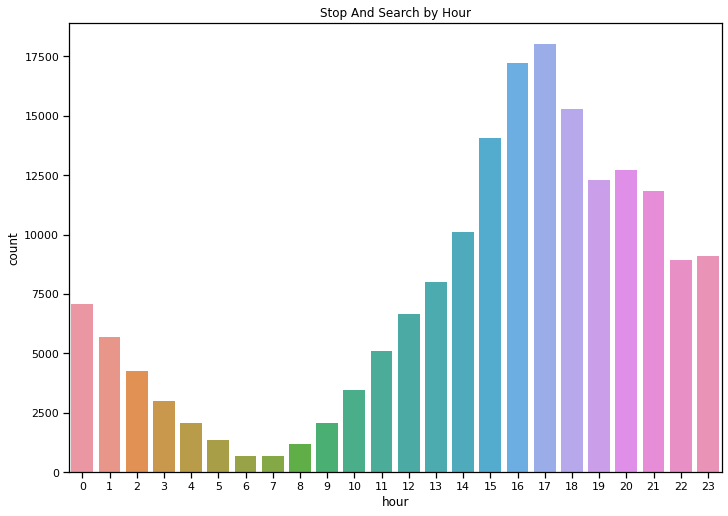

In [23]:
sns.countplot(x="hour", data=df)
plt.title('Stop And Search by Hour');

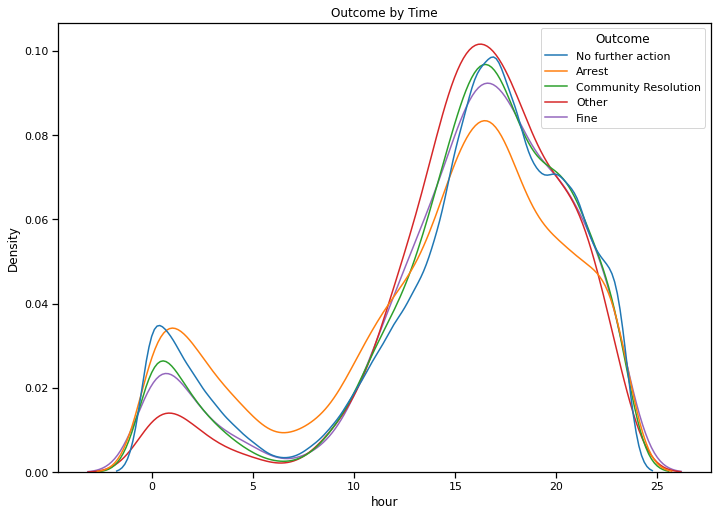

In [24]:
sns.kdeplot('hour', hue='Outcome', data=df, common_norm=False)
plt.title('Outcome by Time');

These graphs show that most stops occur from around 4PM-1AM. This may a bit obvious since that is when most people are off from work and/or school. However, the second graph gives detail on what outcomes are happen more likely on specific times of the time. 
The first peak happens around 12AM-2AM, where arrest and no further action are almost equally occur. Meanwhile, the other outcomes peak here as well, but not nearly as much as the other two outcomes. The next peak happens around 5PM. Here every other outcome is more likely than being arrested, most notably the Other outcome. 

# **Data preparation for machine learning**


Before predictions can be made, it is necessary to prepare the data for machine learning. Since the data is primarily categorical data we need to drop additional unecessary columns.

In [25]:
df['Drug Related Stop'] = (df['Reason for Stop'] == 'Drugs')
df['Drug Related Reason'] = (df['Outcome Reason'] == 'B Drugs')

In [26]:
df = df.drop(['Time','Outcome','Date','Subject','Gender','Officer OCU','Reason for Stop','Outcome Reason'], axis=1) 

The listed columns were either already reformatted, or would not work well with the algorithm to make predictions. 

In [27]:
r = np.random.seed(777)
df = pd.get_dummies(df, drop_first=True)

After generating some random values for some of the later code. Categories in the dataset get turned into dummy variables so the algorithm can be used. 

#### What can we do to help with the unbalanced dataset?

In [28]:
minority_rows = df[df['Further Action'] == 1]
minority_count = minority_rows.shape[0]
majority_rows = df[df['Further Action'] == 0].sample(minority_count, replace=False)
df_balanced = pd.concat([majority_rows, minority_rows])
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

target = 'Further Action'
predictors = list(df_balanced.columns)
predictors.remove(target)

X = df_balanced[predictors].values
y = df_balanced[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=r )

In [29]:
print(X_train.shape)
print(y_train.shape)

(58184, 69)
(58184,)


Here the majority rows are undersampled so we can try to get a more accurate algorithm. If left unchecked, the resulting algorithm results might be skewed towards a specific prediction. 

#### Baseline Accuracy

In [30]:
s = pd.Series(y_train)
mode = s.mode()
(y_train == mode[0]).mean().round(3)

0.501

This is the accuracy that we would have from simply guessing if there was any further action of not. Since this is a smaller balanced dataset, the accuracy rate is around 50%.

# **Machine learning**


#### Building the classification tree

In [31]:
clf = DecisionTreeClassifier(max_depth = 10,  random_state = r)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10)

To begin, we use a max tree depth of 10 to try to achieve overfitting, and make our model flexible. 

In [32]:
import graphviz
from sklearn.tree import export_graphviz
def plot_tree_custom(clf):
    
    
    target_names = ['Further Action', 'No Further Action']
    dot_data = export_graphviz(clf, precision=2,
                         feature_names=predictors,  
                         proportion=True,
                         class_names = target_names,
                         filled=True, rounded=True,  
                         special_characters=True)

    graph = graphviz.Source(dot_data)  
    return graph

#### First Classification Tree

In [33]:
plot_tree_custom(clf)

#### What is our accuracy with our classification tree so far?

In [34]:
tree_cv = []

accs = cross_val_score(clf, X_train, y_train, scoring="accuracy", cv=20)
accs.mean().round(3)

0.582

With our initial classification, the cross-validation accuracy is around 58%.
So about an 8% increase in accuracy.

#### What can a learning curve show us?

In [35]:
def plot_learning_curve(clf, X_train, y_train): 
    train_sizes, train_scores, test_scores = \
    learning_curve(clf, X_train, y_train, cv=10, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, label='train')
    plt.plot(train_sizes, test_scores_mean, label='test')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.title('Learning curve, classification tree')
    plt.legend();

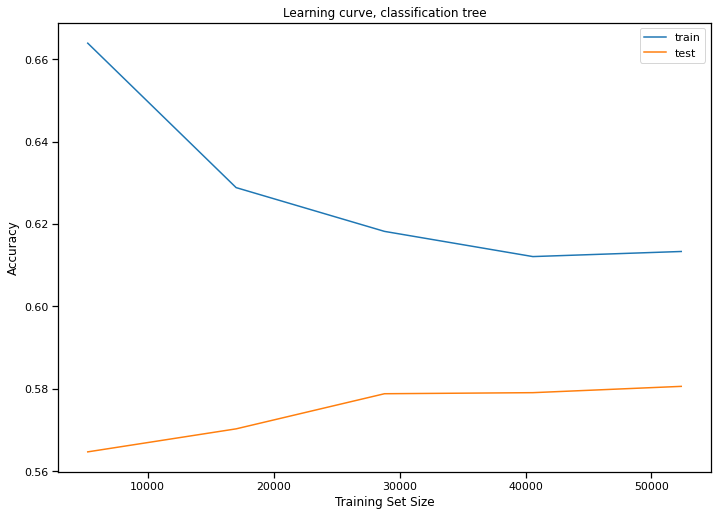

In [36]:
plot_learning_curve(clf, X_train, y_train);

This learning curve indicates that this is a sign of high variance. However, there seems to be an issue of the classication actually becoming less accurate and stagnating as the training set is increased. 

#### Hyperparameter tuning

In [37]:
tree_cv = GridSearchCV(cv = 10, estimator=DecisionTreeClassifier(),
  param_grid=[{'max_depth': range(2, 10),
  'max_features': ['auto', None],
  'min_samples_leaf': range(10, 50, 10)}],
  scoring='accuracy')
tree_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid=[{'max_depth': range(2, 10),
                          'max_features': ['auto', None],
                          'min_samples_leaf': range(10, 50, 10)}],
             scoring='accuracy')

Here hyperparameter tuning was performed using grid search with cross validation. This is used to try to find some ideal hyperparameters for the classifcation tree. Next we show some possible good parameters for the classication.

In [38]:
print(tree_cv.best_params_)

{'max_depth': 9, 'max_features': None, 'min_samples_leaf': 40}


From this grid search, it shows that the best parameters are 9 depth, and a minimum of 40 training examples. Now lets see if there's any improvement if in our cross-validation score.

In [39]:
tree_cv.best_score_.round(3)

0.585

Although not significant, there was around 0.02% improvement.

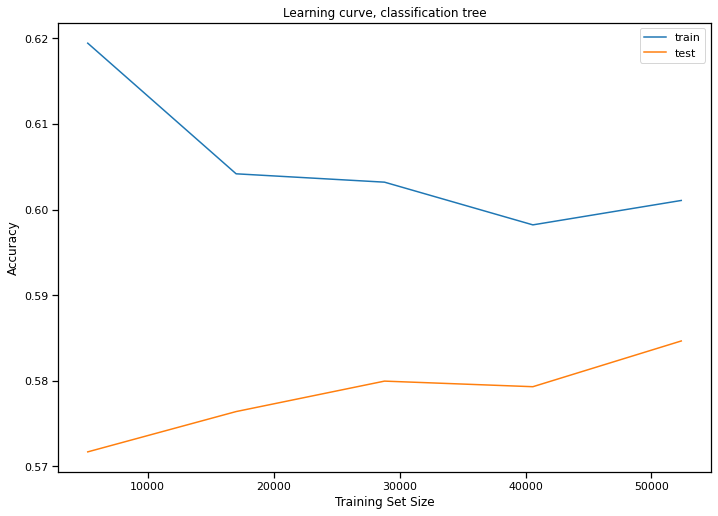

In [40]:
plot_learning_curve(tree_cv.best_estimator_,X_train,y_train);

In the end, the learning curve ended up with a similar trend to the previous one. High variance, with the train and test lines almost running in parallel. 

#### Plot a tree with the best estimators

In [41]:
plot_tree_custom(tree_cv.best_estimator_);

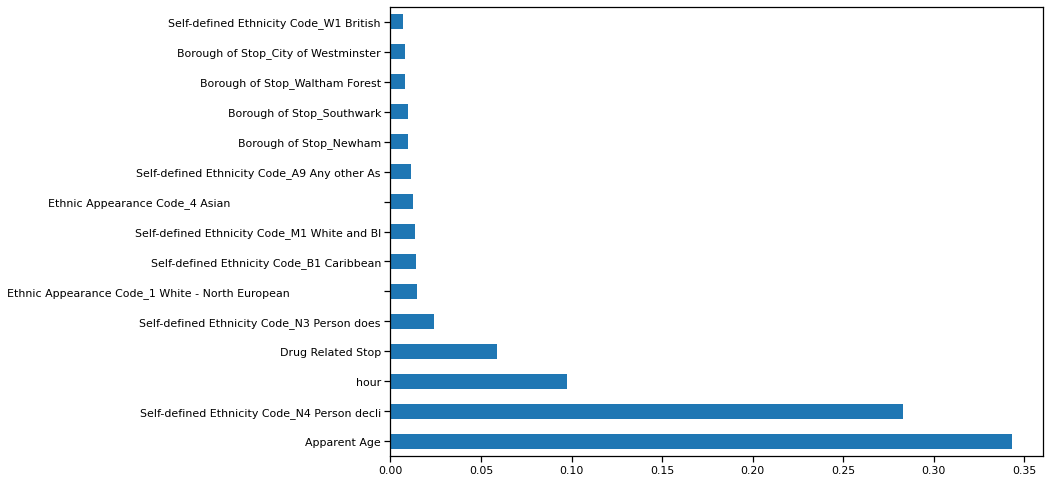

In [42]:
importances = tree_cv.best_estimator_.feature_importances_

pd.Series(tree_cv.best_estimator_.feature_importances_, index=predictors).sort_values(ascending=False).head(15).plot.barh();

The graph above shows how important several on the inpputed features are. The 5 most imporant are Apparent Age, Person Declining, hour, Drug Related Stop, and Person does not know. The rest seem to be about equally imporant or slightly less important.

Can we visualize how well the classification predicted?

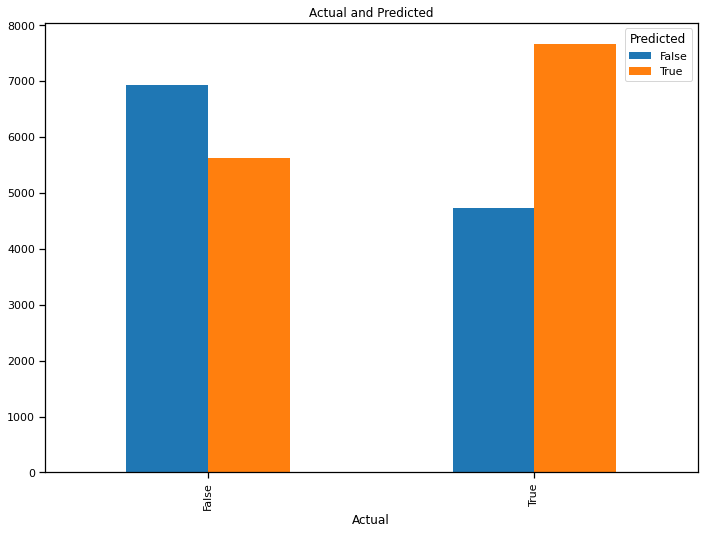

In [43]:
y_predict = clf.predict(X_test)
cm = pd.crosstab(y_test, y_predict, rownames = ['Actual'], colnames = ['Predicted'])
cm.plot.bar() 
plt.title('Actual and Predicted');

Although the classification guessed more times correctly than wrong, the prediction is a little too close be of real use. 

#### Resulting Model

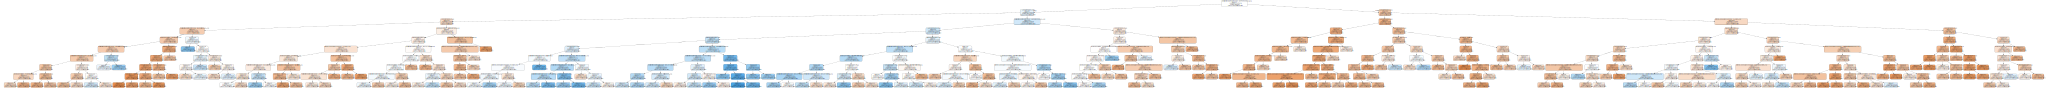

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=r )

clf = DecisionTreeClassifier(max_depth = 9, min_samples_leaf = 40, random_state = r)
clf.fit(X_train, y_train)

plot_tree_custom(clf)

In [45]:
tree_cv = []

accs = cross_val_score(clf, X_train, y_train, scoring="accuracy", cv=20)
accs.mean().round(3)

0.587

Using the information gained so far, this is the resulting classification model. 

# **Conclusion**

While the classfication tree was able to predict whether police took further action after a stop and search, it was not that much higher than a normal guess. It made  8% more accurate predictions, but not good enough to be of any real use. 
However, there were some interesting findings when looking at the most important features. The stopped person's apparent age, whether they declined giving their enthnicty, the time of day, and if the stop and search was drug related showed they heavily affected the outcome of these stops. From the looks of it, it seems police tend to stop younger people more often than other age groups, during later times of day. Addtionally, if the person stopped was asked their ethnicity but either didn't know or declined to respond, they were more likely to not be let go without consequence. 
